# Theoretical Biophysics
## Nubots and Percolation Programming Project


#### Goals:

- Compute simple shapes
- Implement methods from [the paper](https://dna.hamilton.ie/woods/download/nubots.pdf)
- Maybe try different lattices (e.g. 'sparse' lattices)
- Examine percolation phenomena for the Sierpinski gaskets

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random as rd
import statistics
from scipy.optimize import curve_fit
from collections import Counter
from methods import *

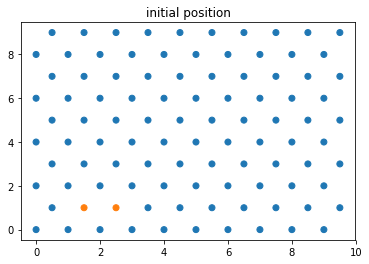

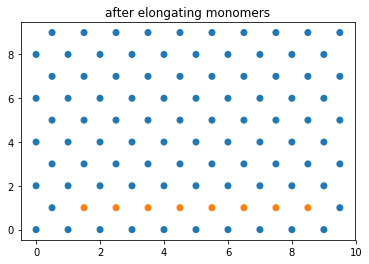

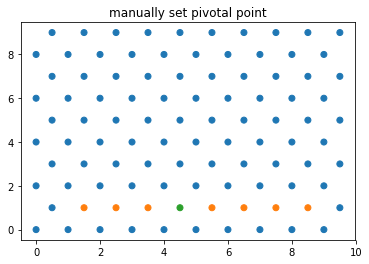

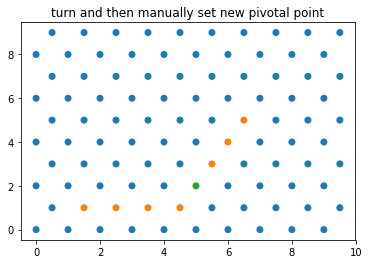

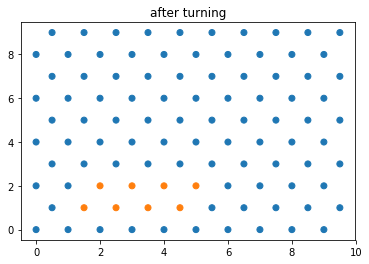

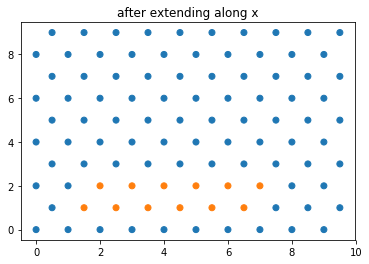

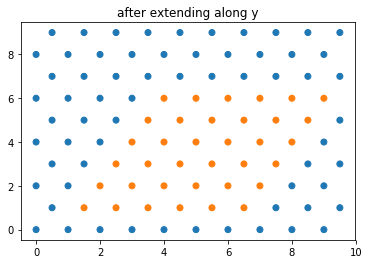

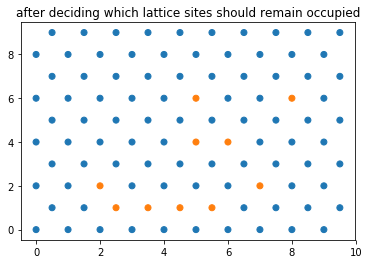

In [2]:
## Monomer Grid

height, width = 10,10

grid = HexGrid(NubotCell, height, width, {"state": 0})

"""
In the following, we are going to create a certain pattern - a smiley face - on a hexagonal
grid. In doing so, we make use of basic cellular automata functions, namely: growing a line
of monomers along a certain direction, and letting such a line take a turn around a user-defined
pivotal monomer
These methods are defined in the header methods.py
"""

# initialize grid with 2 monomners
grid.get_cell(2,1).set_state(1)
grid.get_cell(1,1).set_state(1)

grid.plot_states([0, 1,2,3])
plt.title("initial position")
plt.show()

# let them grow into a line
steps = 6
for _ in range(steps):
    grid.perform_step()

grid.plot_states([0,1,2,3])
plt.title(f"after elongating monomers")
plt.show()


# define where to buckle: set pivotal monomer
grid.get_cell(4,1).set_state(2)
grid.get_cell(5,1).set_state(1)

grid.plot_states([0,1,2,3])
plt.title("manually set pivotal point")
plt.show()

# ... and turn around this pivotal monomer
grid.simple_turn(np.array([-1, 1]), np.array([5, 1]), start=True)

#reset all states to 1
grid.reset_states()

# now define pivotal monomer for second turn
grid.get_cell(4,2).set_state(2)

grid.plot_states([0,1,2,3])
plt.title("turn and then manually set new pivotal point")
plt.show()

# perform second turn
grid.simple_turn(np.array([-1, -1]), np.array([4, 3]), start=True)
grid.reset_states()


grid.plot_states([0,1,2,3])
plt.title(f"after turning")
plt.show()

# let the two adjacent lines grow a bit further horizonatally ...
steps = 2
for _ in range(steps):
    grid.perform_step()

grid.plot_states([0,1,2,3])
plt.title(f"after extending along x")
plt.show()


# ... and vertically. Note that we use the perform_step_upward() rather than the perform_step() method
steps = 4
for _ in range(steps):
    grid.perform_step_upward()


grid.plot_states([0,1,2,3])
plt.title(f"after extending along y")
plt.show()

# now draw smiley face: decide which monomers to keep and which to omit
grid.draw(1, 1)

grid.plot_states([0,1,2,3])
plt.title(f"after deciding which lattice sites should remain occupied")
plt.show()


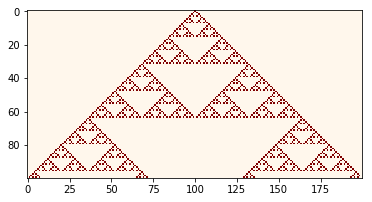

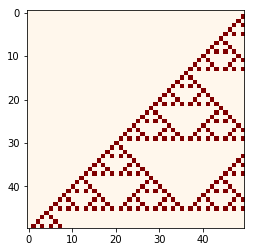

In [3]:
## Sierpinski triangles

# Define the 2d grid / field
N = 200
t = 100

field = np.zeros((t, N))
field[0, int(N/2)] = 1

for i in range(0, t - 1):
    combined = np.logical_xor(field[i,:-2].astype('bool'), field[i,2:].astype('bool'))
    field[i+1,1:-1] = combined
    
    # old implementation (slower)
    
    #for x in range(1, N - 1):
    #    field[i+1, x] = bool(field[i, x-1]) ^ bool(field[i, x+1]) #logical XOR

plt.imshow(field, cmap="OrRd")
plt.show()
plt.imshow(field[50:,:50], cmap="OrRd")
plt.show()
#plt.savefig('sierpinski_automaton.png', dpi=300, format='png')

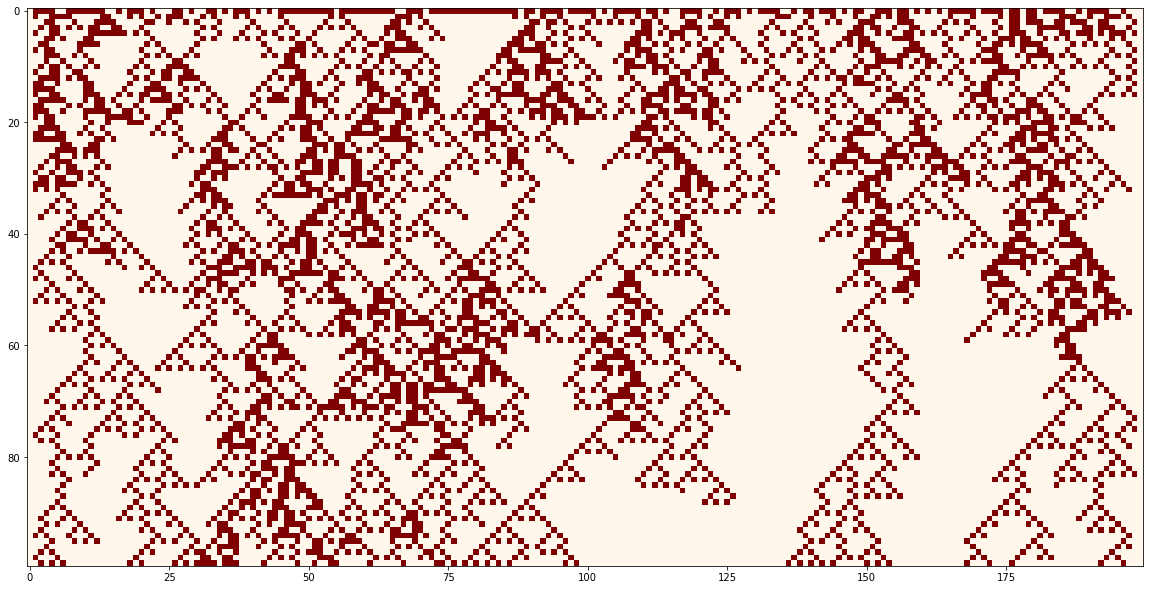

In [82]:
## Probabilistic Sierpinski triangles

N = 200
t = 100

field = np.zeros((t, N))

# p(0 / unocc.) = 1/3, p(1 / occ.) = 2/3
field[0, :] = np.random.choice([0,1],  size=N, p=[1/3, 2/3])

for i in range(0, t - 1):
    random_prob = np.random.random(size=N-2)
    mask = random_prob>0.2

    combined = np.logical_xor(field[i,:-2].astype('bool'), field[i,2:].astype('bool'))
    field[i+1,1:-1] = np.where(mask, combined, 0)
    #for x in range(1, N - 1):
     #   random_prob = rd.uniform(0, 1)
     #   if random_prob > 0.2:      # larger values usually lead to a small tree. where lays p_c and why?
     #       field[i+1, x] = bool(field[i, x-1]) ^ bool(field[i, x+1])
            
plt.figure(figsize=(20,20))
plt.imshow(np.clip(field, a_min=0, a_max=1), cmap="OrRd")
plt.show()
#plt.savefig('sierpinski_automaton.png', dpi=300, format='png')

Above's plot raises the question, whether a critical probability exists and where the critical probability threshold for percolation is located if existence is given.

In [8]:
## Routines to receive the 'percolation probability'

# first set of probabilities to check
p = [0.45, 0.55, 0.65, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.9, 0.99]

# cutoff probability for later determination of p_c
p_cutoff = 0.4

def t_dependence(pp_list, p, p_cutoff):
    """
    computes the 'exact' position of the intersection by linear interpolation
    
    pp_list:  list,  contains the percolation probabilities to scan for the threshold
    p:        list,  contains the rule probabilities
    p_cutoff: float, threshold probability
    
    """
    
    i = 0
    while pp_list[i] < p_cutoff:
        i += 1
    
    # interpolate linearly between the upper and lower threshold
    slope = (pp_list[i]-pp_list[i-1]) / (p[i]- p[i-1])
        
    return (p_cutoff - pp_list[i-1] + slope*p[i-1]) / slope

def testfunction(t, iterations, p, p_cutoff):
    """
    computes the percolation probability by iteration; rule probability can be varied
    
    t:          int,   grid length
    iterations: int,   number of grid over which the percolation probability mean gets taken
    p:          list,  rule probabilities, for which grids are computed
    p_cutoff:   float, threshold probability
    
    """
    
    N = t
    counts = []
    
    for k in range(len(p)):
        
        counter = 0     # count whether or whether not of full-length triangles exist

        for l in range(iterations): # mean procedure for percolation probabilities

            field = np.zeros((t, N))
            field[0, :] = np.random.choice([0,1],  size=N, p=[1/3, 2/3])

            for i in range(0, t - 1):
                random_prob = np.random.random(size=N-2)
                mask = random_prob<p[k]
                
                combined = np.logical_xor(field[i,:-2].astype('bool'), field[i,2:].astype('bool'))
                field[i+1,1:-1] = np.where(mask, combined, 0)
            if np.sum(field[-1,:]) > 0:
                counter += 1

        counts.append(counter)
        #print(k+1, " of ", len(p))
    
    plt.imshow(field, cmap="OrRd")  # plot field to show number of 'steps', if t is also varied
    plt.show()
    
    return [x / iterations for x in counts], t_dependence([x / iterations for x in counts], p, p_cutoff)

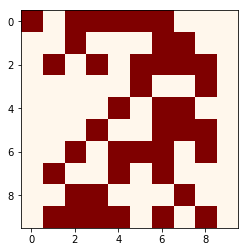

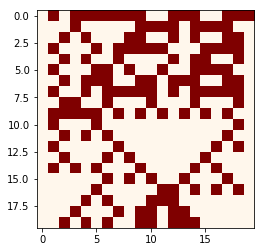

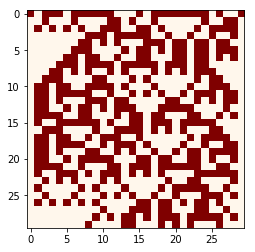

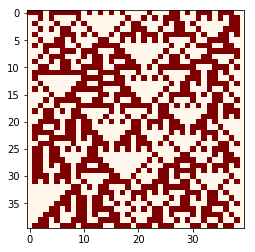

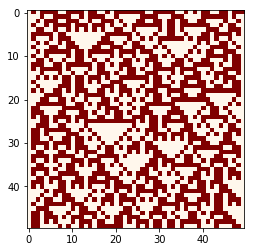

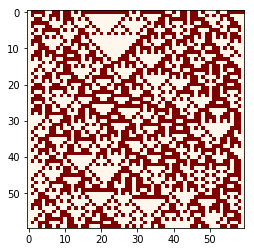

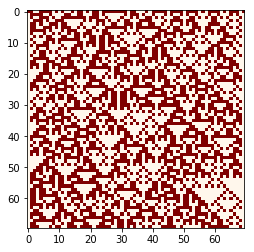

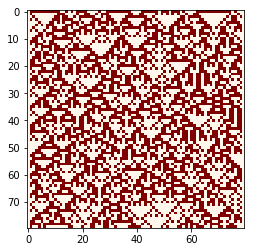

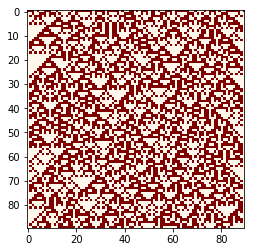

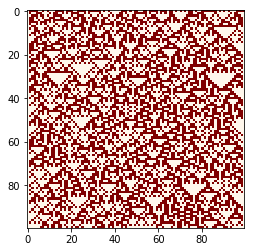

In [5]:
## Evaluation of test function

length = 10
T = np.linspace(10,100,length,dtype="int")

numberOFiters = 200

normCounts = []
for j in range(len(T)):   # evaluate various grid lengths
    normCounts.append(testfunction(T[j], numberOFiters, p, p_cutoff))

(0, 1)

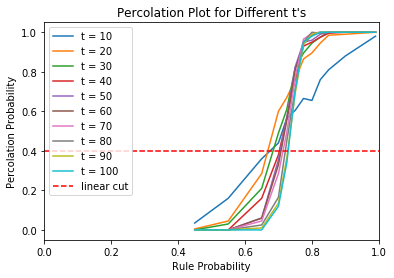

In [6]:
## Percolation plot I

for i in range(length):
    plt.plot(p,normCounts[i][0], label="t = {}".format(T[i]))

# plot p_cutoff
plt.plot([0,1],[p_cutoff, p_cutoff], label="linear cut", color="r", linestyle="dashed")
plt.title("Percolation Plot for Different t's")
plt.xlabel("Rule Probability")
plt.ylabel("Percolation Probability")
plt.legend()
plt.xlim([0,1])

(0, 1)

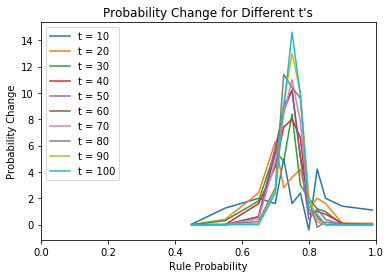

In [7]:
## Plot of probability change as an example for further work (Binder-cumulant (?) )

for i in range(length):
    
    difference = [normCounts[i][0][0]]  # set first list value as first finite difference quotient value
                                        # (one could also use 0 but finite value may indicate p_0 too close to p_c)
    
    for j in range(len(normCounts[i][0])-1):
        difference.append( (normCounts[i][0][j+1]-normCounts[i][0][j]) / (p[j+1]-p[j]) )

    plt.plot(p,difference, label="t = {}".format(T[i]))
    
#plt.plot(p,difference, label="t = {}".format(T[i])) # only show last plot

plt.title("Probability Change for Different t's")
plt.xlabel("Rule Probability")
plt.ylabel("Probability Change")
plt.legend()
plt.xlim([0,1])

According to [this, p. 39](https://katalog.ub.uni-heidelberg.de/cgi-bin/titel.cgi?katkey=68396046&sess=abe3963734e898e1dc1276252a777173&art=f&kat1=freitext&kat2=ti&kat3=au&op1=AND&op2=AND&var1=heermann&var2=&var3=), the susceptibility is defined by

$$
\chi = \sum_{l=1}^{\infty}'l^2 n_l(p)/p
$$

where the prime indicates to leave out the largest cluster of the summation.

0.74 +/-0 0.017


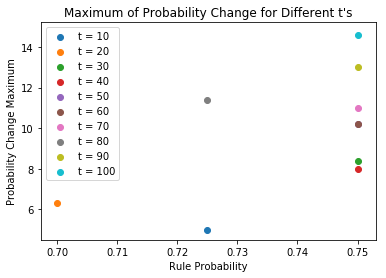

In [8]:
## Plot only the maxima

values = []

for i in range(length):
    difference = [normCounts[i][0][0]] 
    for j in range(len(normCounts[i][0])-1):
        difference.append((normCounts[i][0][j+1]-normCounts[i][0][j])/(p[j+1]-p[j]))
        
    max_value = max(difference)
    max_index = difference.index(max_value)
    
    values.append(p[max_index])  # append for later computations
    
    plt.scatter(p[max_index],max_value, label="t = {}".format(T[i]))

plt.title("Maximum of Probability Change for Different t's")
plt.xlabel("Rule Probability")
plt.ylabel("Probability Change Maximum")
plt.legend()

# further way to calculate p_c, mean and std of maxima
mean = statistics.mean(values)
std = round(statistics.stdev(values),3)

print(mean, "+/-0", std)

Using this plot one can also yield an estimate for the percolation probability by detecting the maximal slope steepness which delivers

$$
p_{c,Sierp.} = 0.740\pm 0.017.
$$

The results of the computation vary, finer grid spacing is recommendable, as clearly only three grid values are seen in above's plot. However, one can see, that the rapid increase of percolation probability happens around the same critical probability and is slightly increasing with 'finer' - larger - grids. Similar to the susceptibility, the rate of change in percolation probability also grows with growing grid size, yielding a more precise critical probability.

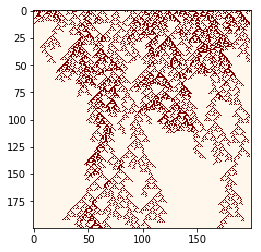

In [9]:
## "precision" calculation for longer cascade and finer steps with same number of iterations

T_prec = 200
p_prec = np.arange(0.65,0.8,0.005)
    
normCounts_prec = testfunction(T_prec, numberOFiters, p_prec, p_cutoff)

p_c =  0.76
p_c =  0.7496


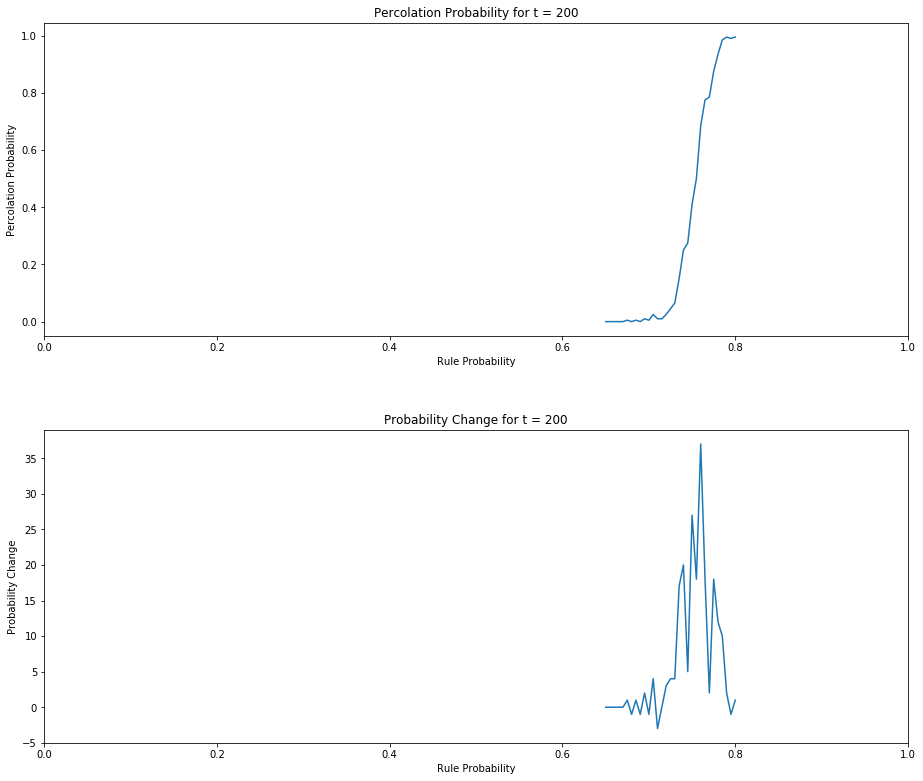

In [10]:
## "precision" plot

# plot the occupation probability
plt.subplot(211)
plt.plot(p_prec,normCounts_prec[0])
plt.title("Percolation Probability for t = 200")
plt.xlabel("Rule Probability")
plt.ylabel("Percolation Probability")
plt.xlim([0,1])

# plot the probability change
plt.subplot(212)
difference_prec = [normCounts_prec[0][0]]
for j in range(len(normCounts_prec[0])-1):
    difference_prec.append((normCounts_prec[0][j+1]-normCounts_prec[0][j])/(p_prec[j+1]-p_prec[j]))
    
plt.plot(p_prec,difference_prec)
plt.title("Probability Change for t = 200")
plt.xlabel("Rule Probability")
plt.ylabel("Probability Change")
plt.xlim([0,1])

plt.subplots_adjust(top=1.5, bottom=-1, left=0, right=2, hspace=0.3, wspace=0.5)

# calculate maximal change for p_c
max_value_prec = max(difference_prec)
max_index_prec = difference_prec.index(max_value_prec)

print("p_c = ", round(p_prec[max_index_prec],4))  # value at maximal change
print("p_c = ", round(normCounts_prec[1],4))      # value at p_cutoff

The next cells contain an approach to obtain $\beta$ and something similar to $\gamma$ by fitting.

a = 0.53+/-0.32
p_c = 0.7583+/-0.0005
gamma = 0.67+/-0.12 (critical exponent)


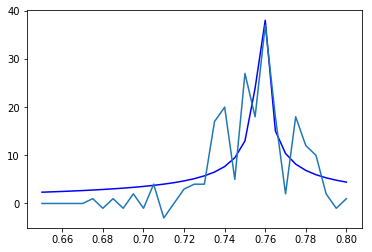

In [11]:
## Fit on rate of change to obtain something similar to exponent \gamma for susceptibility

# define the fit function
def roch(x,a,pc,gamma):
    return a*np.abs(x-pc)**(-gamma)

popt, pcov = curve_fit(roch, p_prec[:], difference_prec[:],[10,0.76,2]) # start parameters

plt.plot(p_prec,roch(p_prec,*popt),color="blue")
plt.plot(p_prec,difference_prec)

# print fit parameters
print("a = {:.2}+/-{:.2}".format(popt[0],np.sqrt(pcov[0,0])))
print("p_c = {:.4f}+/-{:.1}".format(popt[1],np.sqrt(pcov[1,1])))
print("gamma = {:.2f}+/-{:.2} (critical exponent)".format(popt[2],np.sqrt(pcov[2,2])))

The fit highly dependens on start parameters, is therefore not reliable and delivers a too precise result for initial value's uncertainty.

a = 4.5+/-1.0
p_c = 0.7376+/-0.0022
beta = 0.51+/-0.08 (critical exponent)


C:\Users\Public\Anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


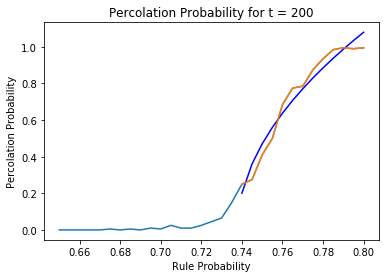

In [40]:
## Fit on the density P_\infty to obtain \beta

plt.plot(p_prec,normCounts_prec[0])

# define the fit function
def dens(x,a,pc,beta):
    return a*(x-pc)**beta

# Make sure to fit only close above p_c
start = 18

popt, pcov = curve_fit(dens, p_prec[start:], normCounts_prec[0][start:],[0.1,0.72,0.2]) # start parameters

plt.plot(p_prec[start:],dens(p_prec[start:],*popt),color="blue")
plt.plot(p_prec[start:],normCounts_prec[0][start:])

plt.title("Percolation Probability for t = 200")
plt.xlabel("Rule Probability")
plt.ylabel("Percolation Probability")

# print fit parameters
print("a = {:.2}+/-{:.2}".format(popt[0],np.sqrt(pcov[0,0])))
print("p_c = {:.4f}+/-{:.2}".format(popt[1],np.sqrt(pcov[1,1])))
print("beta = {:.2f}+/-{:.1} (critical exponent)".format(popt[2],np.sqrt(pcov[2,2])))

The result again heavily depends on the starting point of the fit, is therefore also not a very reliable method.

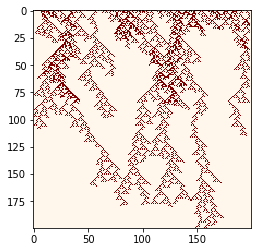

In [43]:
## 2nd try with even smaller area

T2 = 200
p2 = np.arange(0.72,0.785,0.0005)
    
normCounts2 = testfunction(T2, numberOFiters, p2, p_cutoff)

p_c =  0.7605
p_c =  0.7474


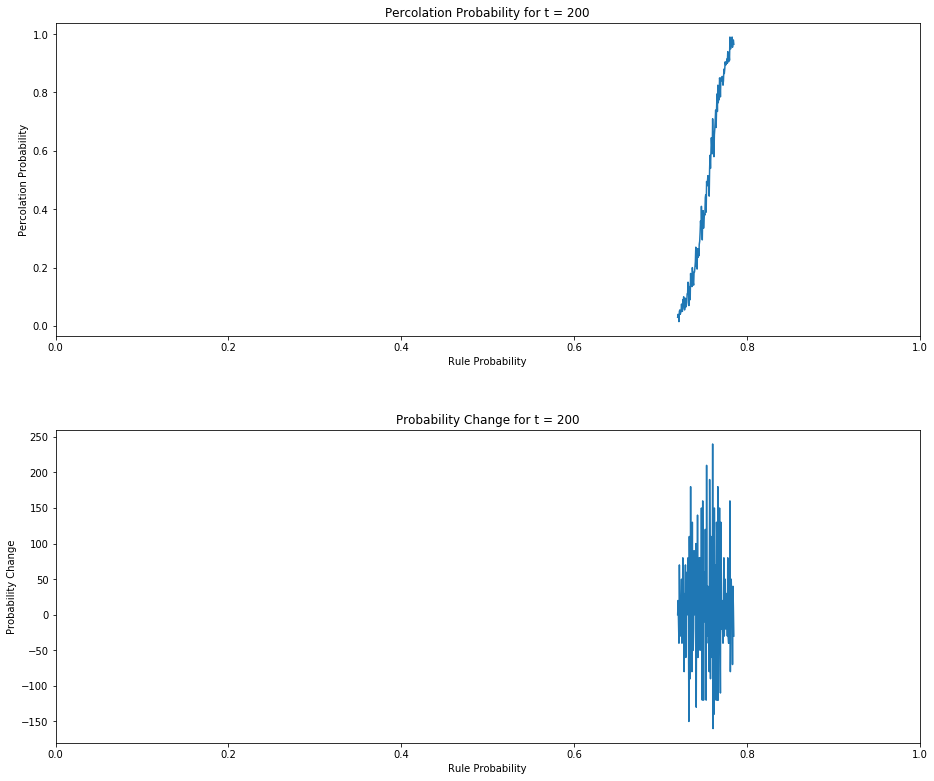

In [45]:
## 2nd "precision" plot 

# plot the occupation probability
plt.subplot(211)
plt.plot(p2,normCounts2[0])
plt.title("Percolation Probability for t = 200")
plt.xlabel("Rule Probability")
plt.ylabel("Percolation Probability")
plt.xlim([0,1])

# plot the probability change
plt.subplot(212)
difference2 = [normCounts2[0][0]]
for j in range(len(normCounts2[0])-1):
    difference2.append((normCounts2[0][j+1]-normCounts2[0][j])/(p2[j+1]-p2[j]))
    
plt.plot(p2,difference2)
plt.title("Probability Change for t = 200")
plt.xlabel("Rule Probability")
plt.ylabel("Probability Change")
plt.xlim([0,1])

plt.subplots_adjust(top=1.5, bottom=-1, left=0, right=2, hspace=0.3, wspace=0.5)

# calculate maximal change for p_c
max_value2 = max(difference2)
max_index2 = difference2.index(max_value2)

print("p_c = ", round(p2[max_index2],4))  # value at maximal change
print("p_c = ", round(normCounts2[1],4))      # value at p_cutoff

a = 1.5e+01+/-3.3e+01
p_c = 0.7600+/-0.0004
gamma = 0.01+/-0.5 (critical exponent)


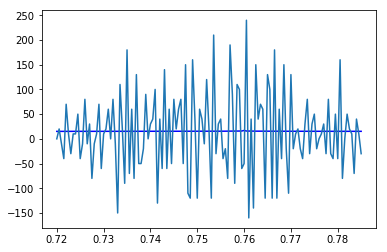

In [46]:
## 2nd Fit on rate of change to obtain something similar to exponent \gamma for susceptibility

popt, pcov = curve_fit(roch, p2[:], difference2[:],[10,0.76,2]) # start parameters

plt.plot(p2,roch(p2,*popt),color="blue")
plt.plot(p2,difference2)

# print fit parameters
print("a = {:.2}+/-{:.2}".format(popt[0],np.sqrt(pcov[0,0])))
print("p_c = {:.4f}+/-{:.1}".format(popt[1],np.sqrt(pcov[1,1])))
print("gamma = {:.2f}+/-{:.2} (critical exponent)".format(popt[2],np.sqrt(pcov[2,2])))

a = 6.7+/-0.85
p_c = 0.7406+/-0.0012
beta = 0.60+/-0.04 (critical exponent)


C:\Users\Public\Anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


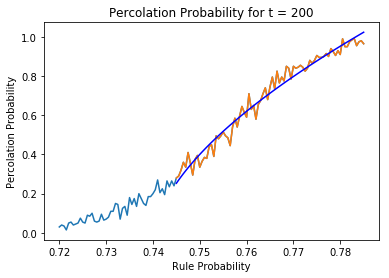

In [52]:
## 2nd Fit on the density P_\infty to obtain \beta

plt.plot(p2,normCounts2[0])

# Make sure to fit only close above p_c
start = 50

plt.plot(p2[start:],normCounts2[0][start:])

popt, pcov = curve_fit(dens, p2[start:], normCounts2[0][start:],[1,0.72,0.5]) # start parameters

plt.plot(p2[start:],dens(p2[start:],*popt),color="blue")

plt.title("Percolation Probability for t = 200")
plt.xlabel("Rule Probability")
plt.ylabel("Percolation Probability")

# print fit parameters
print("a = {:.2}+/-{:.2}".format(popt[0],np.sqrt(pcov[0,0])))
print("p_c = {:.4f}+/-{:.2}".format(popt[1],np.sqrt(pcov[1,1])))
print("beta = {:.2f}+/-{:.1} (critical exponent)".format(popt[2],np.sqrt(pcov[2,2])))

$\textbf{Result:}$ No success with finer probability grid.

A more eleborate way to calculate all relevant quantities (especcially $l$ and $n_l$) would be monitoring the seed numbers (to monitor the affiliation as well as a counter to monitor the size of each cluster.

An easy way to do this, is to implement a counter and append the values, as well as counting the amount of certain values afterwards. This $\textbf{requires}$ $\textbf{numbering the seeds / clusters}$ - or reducing the field to only one seed at random location. This is a not very computationally efficient way, but the one we got working.

In [70]:
## Susceptibility approach

def susceptibility(l, n, p):
    """
    computes the susceptibility values
    
    l:  list of lists, contains the cluster lengths
    n:  list of lists, contains the respective amounts
    p:  list,          contains the rule probabilities
    
    """
    
    susc_list = []
    
    for i in range(len(p)):
        susc_list.append(np.sum(np.asarray(l[i])**2*np.asarray(n[i])/p[i]))
    
    return susc_list


def testfunction2(t, iterations, p, p_cutoff):
    """
    computes the percolation probability by iteration; rule probability can be varied
    
    t:          int,   grid length
    iterations: int,   number of grid over which the percolation probability mean gets taken
    p:          list,  rule probabilities, for which grids are computed
    p_cutoff:   float, threshold probability
    
    Returns:
    mean percolation probability, float
    probability at which p_cutoff is reached, float
    cluster lengths, list of lists
    amount of those lengths, list of lists
    susceptibility, list
    
    """
    
    N = t
    counts = []
    
    # storage for cluster sizes
    l_p = []       # list for a single probability
    matrix_l = []  # list of lists of cluster lengths (for more than one probability, -> 'matrix')
    matrix_n = []  # list of lists of cluster amounts with certain length ( -> 'matrix')
    
    for k in range(len(p)):
        
        counter = 0

        for l in range(iterations): # mean procedure for percolation probabilities

            field = np.zeros((t, N))
            field[0, np.random.randint(0,t)] = 1   # changing to only one, random seed
            
            cluster_size = 1   # with a seed, length is 1
            
            for i in range(0, t - 1):
                random_prob = np.random.random(size=N-2)
                mask = random_prob<p[k]
                
                combined = np.logical_xor(field[i,:-2].astype('bool'), field[i,2:].astype('bool'))
                field[i+1,1:-1] = np.where(mask, combined, 0)
                cluster_size += np.sum(mask)

                l_p.append(cluster_size)  # list of cluster lengths
                        
            if np.sum(field[-1,:]) > 0:
                counter += 1

        counts.append(counter)
        
        # obtain length of clusters and their amount
        max_elem = max(l_p)
        
        count_dict = dict(Counter([i for i in l_p if i != max_elem]).items())
        l = list(count_dict.keys())
        n = list(count_dict.values())
        
        matrix_l.append(l)              # append to matrices
        matrix_n.append(n)        
        
    plt.imshow(field, cmap="OrRd")  # plot field to show number of 'steps', if t is also varied
    plt.show()
    
    return [x / iterations for x in counts], t_dependence([x / iterations for x in counts], p, p_cutoff), matrix_l, matrix_n, susceptibility(matrix_l, matrix_n, p)

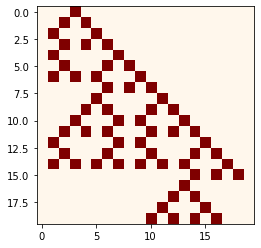

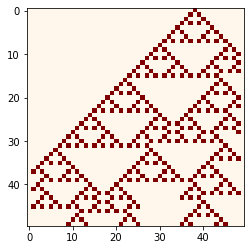

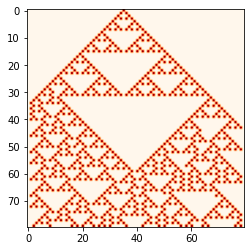

In [76]:
#%%timeit

## Evaluation of test function 2

length = 3
T = np.linspace(20,80,length,dtype="int")

numberOFiters = 200

normCounts_susc = []
for j in range(len(T)):   # evaluate various grid lengths
    normCounts_susc.append(testfunction2(T[j], numberOFiters, p, p_cutoff))

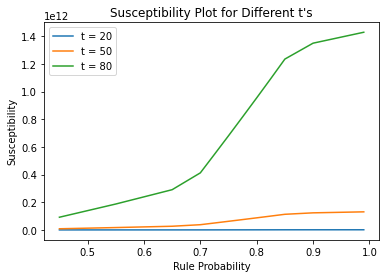

In [77]:
## Susceptibility plot

for i in range(len(normCounts_susc)):
    plt.plot(p,normCounts_susc[i][4], label="t = {}".format(T[i]))

plt.title("Susceptibility Plot for Different t's")
plt.xlabel("Rule Probability")
#plt.yscale("log")
plt.ylabel("Susceptibility")
plt.legend()

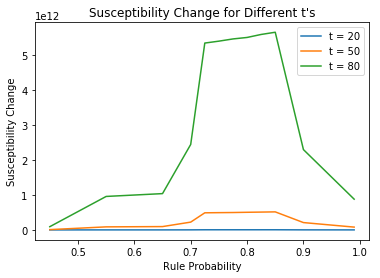

In [113]:
## Plot of susceptibility change

for i in range(len(normCounts_susc_prec)):
    
    difference_susc_prec = [normCounts_susc_prec[i][4][0]]  # set first list value as first finite difference quotient value
                                             # (one could also use 0 but finite value may indicate p_0 too close to p_c)
    
    for j in range(len(normCounts_susc_prec[i][4])-1):
        difference_susc_prec.append( (normCounts_susc_prec[i][4][j+1]-normCounts_susc_prec[i][4][j]) / (p[j+1]-p[j]) )

    plt.plot(p,difference_susc_prec, label="t = {}".format(T[i]))
    
#plt.plot(p,difference, label="t = {}".format(T[i])) # only show last plot

plt.title("Susceptibility Change for Different t's")
plt.xlabel("Rule Probability")
plt.ylabel("Susceptibility Change")
plt.legend()
#plt.xlim([0,1])

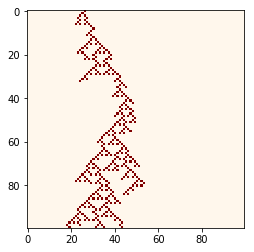

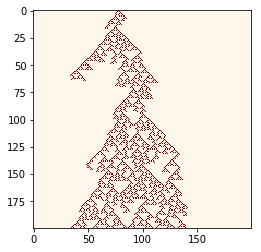

In [19]:
## Closer examination near critical probability

length = 2
T = np.linspace(100,200,length,dtype="int")
p_prec = np.arange(0.7,0.85,0.005)

numberOFiters = 200

normCounts_susc_prec = []
for j in range(len(T)):   # evaluate various grid lengths
    normCounts_susc_prec.append(testfunction2(T[j], numberOFiters, p_prec, p_cutoff))

At p_cutoff for t = 100, rule probability = 0.796 
At p_cutoff for t = 200, rule probability = 0.7996666666666667 


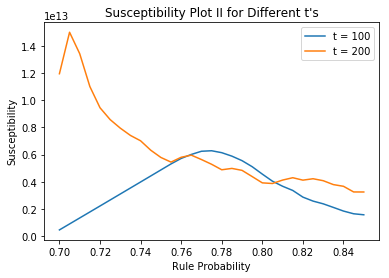

In [27]:
## Susceptibility plot II

for i in range(len(normCounts_susc_prec)):
    plt.plot(p_prec,normCounts_susc_prec[i][4], label="t = {}".format(T[i]))
    print("At p_cutoff for t = {}, rule probability = {} ".format(T[i], normCounts_susc_prec[i][1]))

plt.title("Susceptibility Plot II for Different t's")
plt.xlabel("Rule Probability")
#plt.yscale("log")
plt.ylabel("Susceptibility")
plt.legend()

The susceptibility gets a kink, as also expected for a randomly filled the grid, however only at larger $t$. This may somehow be expected, depending on whether this percolation problem has or has not a (second order) phase transition. The last plot for $t = 200$ also indicates $p_c$ lower as up to now expected and also received from the percolation probability threshold.

The last plot again indicates no kinks, raising the question from where they arise in the aboves plot.

One major problem might arise from above's formula

$$
\chi = \sum_{l=1}^{\infty}'l^2 n_l(p)/p
$$

$\textit{testfunction2}$ omits the largest cluster from the summation but these might vary in size. To be clearer: The aim of the primed summation is to leave out the 'infinite cluster' which span the whole grid. As the Sierpinski Gasket grows, it gets more branches, which determine the used size. Therefore the size of two 'infinite' - full-grid-spanning - clusters may vary and only the largest one is left out. This might lead to the observed sigmoid shape of the susceptibility and not the expected one with singularity.

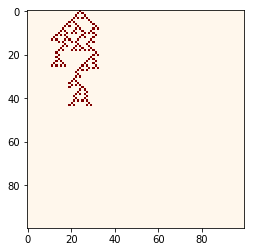

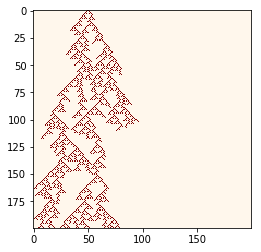

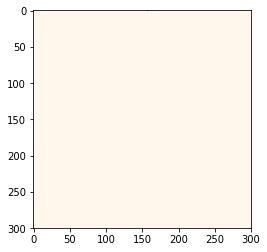

In [15]:
## test with less iterations and larger length

length = 3
T = np.linspace(100,300,length,dtype="int")

numberOFiters = 50
p = np.arange(0.65,0.85,0.025)

Counts_susc = []
for j in range(len(T)):   # evaluate various grid lengths
    Counts_susc.append(testfunction2(T[j], numberOFiters, p, p_cutoff))

(0.5, 0.95)

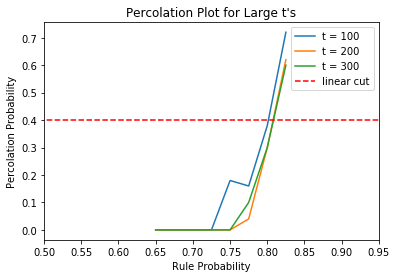

In [16]:
## Percolation plot III

for i in range(length):
    plt.plot(p,Counts_susc[i][0], label="t = {}".format(T[i]))

# plot p_cutoff
plt.plot([0,1],[p_cutoff, p_cutoff], label="linear cut", color="r", linestyle="dashed")
plt.title("Percolation Plot for Large t's")
plt.xlabel("Rule Probability")
plt.ylabel("Percolation Probability")
plt.legend()
plt.xlim([0.5,0.95])


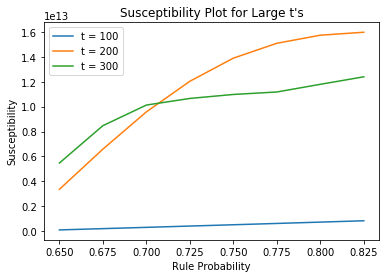

In [17]:
## Susceptibility plot III

for i in range(len(Counts_susc)):
    plt.plot(p,Counts_susc[i][4], label="t = {}".format(T[i]))

plt.title("Susceptibility Plot for Large t's")
plt.xlabel("Rule Probability")
#plt.yscale("log")
plt.ylabel("Susceptibility")
plt.legend()

The last result we will show here is the inverse plot of the cutoff probabilities.

Text(0,0.5,'Percolation Probability')

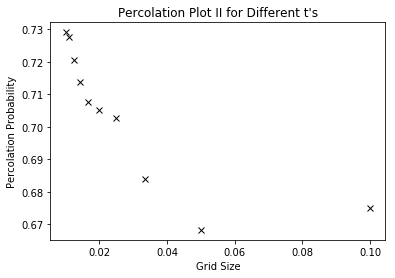

In [12]:
## Percolation plot II

for i in range(length):
    plt.plot(1/T[i],normCounts[i][1], 'x', color='black')
    
# show the cascades
#plt.plot([32,32],[0.66,0.73], color="r", linestyle="dashed")
#plt.plot([64,64],[0.66,0.73], color="r", linestyle="dashed")
#plt.plot([96,96],[0.66,0.73], color="r", linestyle="dashed")

plt.title("Percolation Determined by $p_{cutoff}$ for Different t's")
plt.xlabel("Grid Size 1/N")
plt.ylabel("Percolation Probability")

$\textbf{Aim:}$ Plot $1/N$ for extrapolation $N \rightarrow \infty$; however, it is not clear how to do the extrapolation except that $p \leq 1$ is a limit. Depending on Fit parameters or extrapolation rule results will vary, which is again inaccurate.

#### Final Summary of the Percolation Behaviour

The percolation probability for a randomly occupied [Archimedean square lattice](https://en.wikipedia.org/wiki/Percolation_threshold#Thresholds_on_Archimedean_lattices) amounts

$$
p_c \approx 0.59274
$$

which is - as intuitively expected - smaller than the critical probability obtained above with various methods 

$$
p_{c,\text{Sierp.}} \approx 0.75\pm 0.02 > p_c
$$

for occupying the lattice according to a rule which only takes parts of the lattice.

One should keep in mind, that for (specific) rules it may be questionable, whether computing the percolation probability is meaningful or not. This question arises from the susceptibility plot, which do not indicate the expected kind of phase transition. However, this could also be a mistake in the computation, which was also discussed above. Another point which strengthens the suspicion of a wrong calculation of the susceptibility is the fractal dimension according to [this](http://people.physik.hu-berlin.de/~sokolov/STAT18/Percolation.pdf) (also available in folder). According to this source, $d_f \approx 1.585$ which with

$$
d_f = d - \frac{\beta}{\nu}
$$

implies $\beta \neq 0$, leading to the conclusion that there should be a critical probability. This result is consistent with the naive idea of the phase transition being caused by 'contact' from one side to its opponent, which is the same in both randomly and by rules occopied grids.